In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from nam.wrapper import NAMClassifier

# -------------------- Config --------------------
random_state = 2025
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

categorical_features = {
    "sex": ["Female", "Male"],
    "c_charge_degree": ["Misdemeanor", "Felony"],
    "race": ["African American", "Asian", "Caucasian", "Hispanic", "Native American", "Other"],
}
categorical_label_maps = {
    'race': ['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other'],
    'sex': ['Female', 'Male'],
    'c_charge_degree': ['Misdemeanor', 'Felony'],
}
feature_map = {
    'age': 'Age',
    'race': 'Race',
    'priors_count': 'Priors Count',
    'length_of_stay': 'Length of Stay',
    'sex': 'Sex',
    'c_charge_degree': 'Charge Degree'
}
OUT_DIR = './figures'
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- Utils --------------------
def shade_by_density_blocks_nam(X_orig, feature_index, ax, is_categorical, n_blocks=5,
                                color=[0.9, 0.5, 0.5], min_y=None, max_y=None):
    """Density shading over the FULL observed x-range (no external xlims)."""
    if isinstance(X_orig, pd.DataFrame):
        X_orig = X_orig.to_numpy()
    x = X_orig[:, feature_index]

    if min_y is None or max_y is None:
        min_y, max_y = ax.get_ylim()

    is_integer_discrete = np.allclose(x, np.round(x))

    if not is_categorical and not is_integer_discrete:
        x_min, x_max = np.min(x), np.max(x)
        segments = np.linspace(x_min, x_max, n_blocks + 1)
        density, _ = np.histogram(x, bins=segments)
        norm = density.max() if density.max() > 0 else 1.0
        for i in range(n_blocks):
            alpha = min(1.0, 0.01 + density[i] / norm)
            rect = patches.Rectangle((segments[i], min_y - 1),
                                     segments[i + 1] - segments[i],
                                     max_y - min_y + 1,
                                     linewidth=0, edgecolor=color, facecolor=color, alpha=alpha)
            ax.add_patch(rect)
    else:
        cats = np.unique(x)
        counts = np.array([(x == c).sum() for c in cats])
        norm = counts.max() if counts.max() > 0 else 1.0
        for i, c in enumerate(cats):
            alpha = min(1.0, 0.01 + counts[i] / norm)
            rect = patches.Rectangle((c - 0.5, min_y - 1), 1.0,
                                     max_y - min_y + 1,
                                     linewidth=0, edgecolor=color, facecolor=color, alpha=alpha)
            ax.add_patch(rect)

def make_X_real_aligned(df, *, X_cols, cont, cat_multi, binary, scaler_mm):
    """Return real-space values aligned to X_cols (cont inverse-transformed)."""
    parts = []
    cont_inv = pd.DataFrame(scaler_mm.inverse_transform(df[cont]), columns=cont, index=df.index)
    for col in X_cols:
        if col in cont:
            parts.append(cont_inv[[col]].to_numpy())
        elif col in cat_multi or col in binary:
            parts.append(df[[col]].to_numpy())
        else:
            raise ValueError(f"Unknown column {col}")
    return np.concatenate(parts, axis=1)

def extract_Z_mean(model, X_tensor, feature_names):
    """Ensemble mean Z (main effects then interactions), with names."""
    X_tensor = X_tensor.to(dtype=torch.float32)
    Zs = []
    with torch.no_grad():
        for learner in model.models:
            learner.eval()
            _, _, me_out, int_out = learner.forward(X_tensor)
            Z = torch.cat([me_out, int_out], dim=1) if int_out.shape[1] > 0 else me_out
            Zs.append(Z.cpu().numpy())
    Zs = np.stack(Zs, axis=0)   # (L, N, U)
    Z_mean = Zs.mean(axis=0)    # (N, U)

    d = me_out.shape[1]
    if getattr(model, "interaction_pairs", None):
        names_int = [f"{feature_names[i]} × {feature_names[j]}" for (i, j) in model.interaction_pairs]
    else:
        names_int = []
    names_all = list(feature_names) + names_int
    return Z_mean, names_all, np.arange(d, dtype=int), np.arange(d, Z_mean.shape[1], dtype=int)

def build_query_for_feature_raw(feature_idx, x_vals_real, X_train_real, X_train, feature_names, categorical_features):
    """Query grid (full observed real range). Maps continuous real→[-1,1] for the NAM."""
    X_query = np.zeros((len(x_vals_real), X_train.shape[1]))
    is_cat = feature_names[feature_idx] in categorical_features
    if is_cat:
        X_query[:, feature_idx] = x_vals_real
    else:
        col = X_train_real[:, feature_idx]
        x_min, x_max = np.min(col), np.max(col)
        if np.isclose(x_max, x_min):
            X_query[:, feature_idx] = 0.0
        else:
            X_query[:, feature_idx] = 2 * (x_vals_real - x_min) / (x_max - x_min) - 1
    return torch.tensor(X_query, dtype=torch.float32)

def discr_from_scores(scores, y):
    """DISCR = 2*(AUC - 0.5). Return 0 if AUC fails."""
    try:
        return 2.0 * (roc_auc_score(y, scores) - 0.5)
    except Exception:
        return 0.0

# -------------------- Load + preprocess (no clipping) --------------------
dataset = pd.read_csv('./data/compas/recid.data', delimiter=' ', header=None)
dataset.columns = ["age", "race", "sex", "priors_count", "length_of_stay",  "c_charge_degree", "two_year_recid"]

cont = ['age', 'priors_count', 'length_of_stay']
cat_multi = ['race']
binary = ['sex', 'c_charge_degree']

dataset[binary] = dataset[binary] - 1
dataset['race'] = dataset['race'] - 1

scaler_mm = MinMaxScaler(feature_range=(-1, 1))
dataset[cont] = scaler_mm.fit_transform(dataset[cont])

X_cols = ["age", "race", "priors_count", "length_of_stay", "sex", "c_charge_degree"]
y_col = 'two_year_recid'
feature_names = X_cols[:]

data_train, data_test = train_test_split(dataset, train_size=0.8, test_size=0.2, random_state=random_state)

X_train = torch.tensor(data_train[X_cols].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(data_train[y_col].to_numpy(), dtype=torch.long)
X_test  = torch.tensor(data_test[X_cols].to_numpy(),  dtype=torch.float32)
y_test  = torch.tensor(data_test[y_col].to_numpy(),   dtype=torch.long)

X_train_real = make_X_real_aligned(data_train, X_cols=X_cols, cont=cont, cat_multi=cat_multi, binary=binary, scaler_mm=scaler_mm)

# -------------------- Train NAM (original inputs) --------------------
model = NAMClassifier(
    num_epochs=100,
    num_learners=100,
    metric='auroc',
    interaction_pairs=[],         # set if you want interactions
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    activation='relu',
)
model.fit(X_train, y_train)

/Users/benny/braindata/pattern-gam-neurips/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import sklearn.metrics as sk_metrics
n_interactions = 0
pred = model.predict_proba(X_test)
auroc = sk_metrics.roc_auc_score(y_test, pred)
print(f"[Original inputs] n_interactions={n_interactions}, AUROC={auroc:.3f}")

[Original inputs] n_interactions=0, AUROC=0.743


In [3]:
# -------------------- Bootstrap (multivariate post-hoc LLR on Z_mean) --------------------
def bootstrap_posthoc_multivar_metrics(model, X_train, y_train, feature_names, n_boot=200, seed=2025):
    """
    For each bootstrap:
      1) Extract Z_mean (N,U)
      2) Fit multivariate LLR: y ~ 1 + Z_mean  -> weights w (size U)
      3) For each i: tilde_f_i = w_i * Z_mean[:, i]
         - SD(tilde_f_i)
         - Fit 1D LLR: y ~ 1 + tilde_f_i -> slope b_i; compute SD(b_i * tilde_f_i)
         - DISCR(tilde_f_i)
         - PROD: SD(tilde_f_i) * SD(b_i * tilde_f_i)
    Returns mean and 95% intervals for each metric (no LL gain).
    """
    rng = np.random.default_rng(seed)
    X_np = X_train.cpu().numpy()
    y_np = y_train.cpu().numpy().astype(int).ravel()
    N = len(y_np)

    # get dimensionality once
    Z_full, names_all, idx_uni, idx_bi = extract_Z_mean(model, X_train, feature_names)
    U = Z_full.shape[1]

    sd_tilde_bt   = np.zeros((n_boot, U))
    sdb_tilde_bt  = np.zeros((n_boot, U))
    discr_bt      = np.zeros((n_boot, U))
    prod_bt       = np.zeros((n_boot, U))
    w_bt          = np.zeros((n_boot, U))

    for b in range(n_boot):
        idx = rng.integers(0, N, size=N)
        Xb = torch.tensor(X_np[idx], dtype=torch.float32)
        yb = y_np[idx]

        Zb, _, _, _ = extract_Z_mean(model, Xb, feature_names)  # (N,U), ensemble fixed

        # multivariate post-hoc LLR (with intercept)
        lr_all = LogisticRegression(penalty=None, solver='lbfgs', fit_intercept=True, max_iter=10000, random_state=seed+b)
        lr_all.fit(Zb, yb)
        w = lr_all.coef_[0]          # (U,)
        w_bt[b, :] = w

        # per-feature metrics using tilde f_i = w_i * Z_i
        for i in range(U):
            tilde = w[i] * Zb[:, i]
            sd_t = float(np.std(tilde, ddof=0))

            # 1-D LLR on tilde to get b_i
            lr_1d = LogisticRegression(penalty=None, solver='lbfgs', fit_intercept=True, max_iter=10000, random_state=seed+b+7)
            lr_1d.fit(tilde.reshape(-1, 1), yb)
            b_i = float(lr_1d.coef_[0, 0])
            sd_b_t = float(np.std(b_i * tilde, ddof=0))

            discr = discr_from_scores(tilde, yb)
            prod  = sd_t * sd_b_t

            sd_tilde_bt[b, i]  = sd_t
            sdb_tilde_bt[b, i] = sd_b_t
            discr_bt[b, i]     = discr
            prod_bt[b, i]      = prod

    def summarize(M):
        return (np.nanmean(M, 0),
                np.nanpercentile(M, 2.5, 0),
                np.nanpercentile(M, 97.5, 0))

    return dict(
        names_all=names_all, idx_uni=idx_uni, idx_bi=idx_bi,
        sd_tilde=summarize(sd_tilde_bt),
        sdb_tilde=summarize(sdb_tilde_bt),
        discr=summarize(discr_bt),
        prod=summarize(prod_bt),
        w=summarize(w_bt),
        raw=dict(sd_tilde=sd_tilde_bt, sdb_tilde=sdb_tilde_bt, discr=discr_bt, prod=prod_bt, w=w_bt)
    )

boot = bootstrap_posthoc_multivar_metrics(model, X_train, y_train, feature_names, n_boot=500, seed=2025)

/var/folders/g7/lnrjgkkx1n3ftgq_zbptpn000000gn/T/ipykernel_46767/2450773979.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


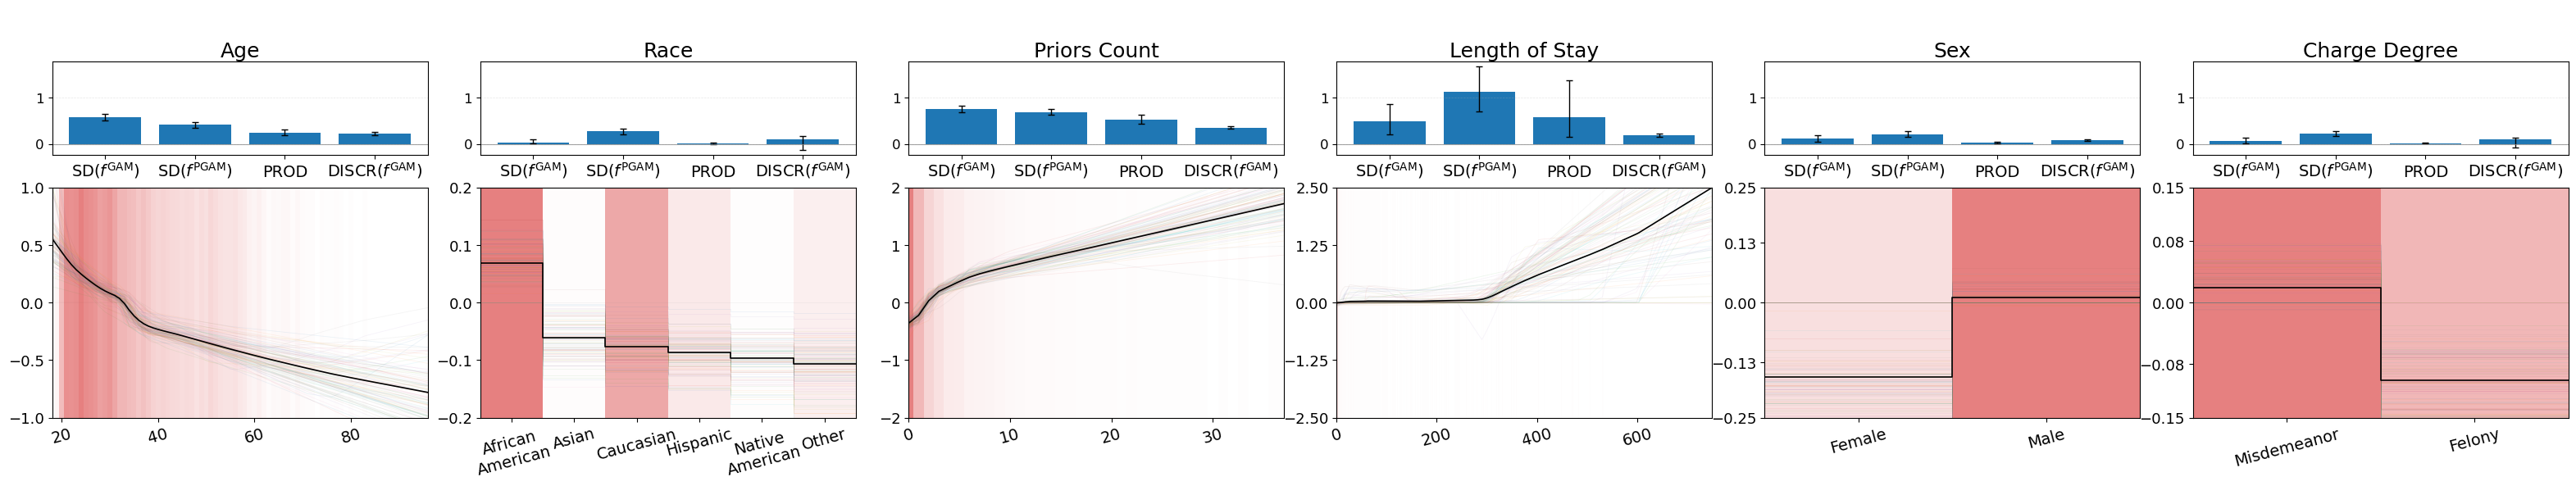

In [9]:
# -------------------- Shapes + bars (full x-range; 4 metrics) --------------------
def plot_shapes_with_bars(
    model, feature_names, feature_map, categorical_features, categorical_label_maps,
    X_train_real, X_train, *,
    sd_tilde, sdb_tilde, prod, discr,  # each is (mean, lo, hi)
    show_learners=True, figsize_per_feature=(6.6, 6.5), height_ratios=(0.3, 1.3, 3.2)
):
    from matplotlib.gridspec import GridSpec
    d = len(feature_names)

    # precompute shape curves over full observed x-range
    x_values = [np.unique(X_train_real[:, j]) for j in range(d)]
    curves = []
    for j, fname in enumerate(feature_names):
        is_cat = fname in categorical_features
        Xq = build_query_for_feature_raw(j, x_values[j], X_train_real, X_train, feature_names, categorical_features)
        preds_all = []
        for learner in model.models:
            learner.eval()
            with torch.no_grad():
                _, _, me_out, _ = learner.forward(Xq)
                preds_all.append(me_out[:, j].cpu().numpy().ravel())
        preds_all = np.stack(preds_all, 0)
        mean_preds = preds_all.mean(0)
        y_min, y_max = -0.5, 0.5  # fixed display range (as before)
        curves.append(dict(is_cat=is_cat, x=x_values[j], preds_all=preds_all, mean=mean_preds, ylim=(y_min, y_max)))

    # shared bar ylim
    stacks = np.concatenate([sd_tilde[1], sd_tilde[2], sdb_tilde[1], sdb_tilde[2], prod[1], prod[2], discr[1], discr[2]])
    lo, hi = float(np.nanmin(stacks)), float(np.nanmax(stacks))
    pad = 0.06 * (hi - lo) if hi > lo else 0.1
    bar_ylim = (lo - pad, hi + pad)

    fig = plt.figure(figsize=(figsize_per_feature[0] * d, figsize_per_feature[1]))
    gs = GridSpec(3, d, figure=fig, height_ratios=height_ratios, hspace=0.28, wspace=0.14)

    y_lims = [(-1.0,1.0),(-0.2,0.2),(-2.0,2.0),(-2.5,2.5),(-0.25,0.25),(-0.15,0.15)]
    y_ticks = [[-1.0, -0.5, 0.0, 0.5, 1.0], [-0.2,-0.1,0.0,0.1,0.2], [-2.0,-1.0,0.0,1.0,2.0], [-2.5,-1.25,0.0,1.25,2.5], [-0.25,-0.13,0.0,0.13,0.25], [-0.15,-0.08,0.0,0.08,0.15] ]
    for j, fname in enumerate(feature_names):
        # Title
        ax_t = fig.add_subplot(gs[0, j]); ax_t.axis("off")
        ax_t.text(0.5, -1.0, feature_map.get(fname, fname), ha="center", va="center", fontsize=18)

        # Bars
        ax_b = fig.add_subplot(gs[1, j])
        bx = np.arange(4.0)
        means = np.array([sd_tilde[0][j], sdb_tilde[0][j], prod[0][j], discr[0][j]])
        yerr_low  = np.array([sd_tilde[0][j]-sd_tilde[1][j], sdb_tilde[0][j]-sdb_tilde[1][j],
                              prod[0][j]-prod[1][j],        discr[0][j]-discr[1][j]])
        yerr_high = np.array([sd_tilde[2][j]-sd_tilde[0][j], sdb_tilde[2][j]-sdb_tilde[0][j],
                              prod[2][j]-prod[0][j],        discr[2][j]-discr[0][j]])
        ax_b.bar(bx, means, width=0.8)
        ax_b.errorbar(bx, means, yerr=[yerr_low, yerr_high], fmt='none', ecolor='k', elinewidth=1, capsize=3)
        ax_b.axhline(0.0, color='gray', linewidth=0.8, alpha=0.7)
        ax_b.set_ylim(*bar_ylim)
        ax_b.set_xticks(bx)
        ax_b.set_xticklabels([r'SD($f^\text{GAM}$)', r'SD($f^\text{PGAM}$)', r'PROD', r'DISCR($f^\text{GAM}$)'], ha="center", va="baseline", fontsize=14)
        ax_b.tick_params(axis='x', pad=15) 

        ax_b.tick_params(axis="y", labelsize=12)
        ax_b.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.5)

        # Shapes (full x-range)
        c = curves[j]
        ax_s = fig.add_subplot(gs[2, j])
        if c["is_cat"]:
            vals = c["x"]; n = len(vals); edges = np.arange(-0.5, n + 0.5, 1.0)
            if show_learners:
                for p in c["preds_all"]:
                    xs = np.empty(2*n); ys = np.empty(2*n)
                    xs[0::2] = edges[:-1]; xs[1::2] = edges[1:]
                    ys[0::2] = p;          ys[1::2] = p
                    ax_s.plot(xs, ys, alpha=0.08, linewidth=0.6)
            xs = np.empty(2*n); ys = np.empty(2*n)
            xs[0::2] = edges[:-1]; xs[1::2] = edges[1:]
            ys[0::2] = c["mean"];  ys[1::2] = c["mean"]
            ax_s.plot(xs, ys, color="black", linewidth=1.2)
            labels = categorical_label_maps.get(fname, None)
            if labels is not None and len(labels) == n:
                ax_s.set_xticks(np.arange(n)); ax_s.set_xticklabels(labels, fontsize=15)
            else:
                ax_s.set_xticks(np.arange(n)); ax_s.set_xticklabels([str(v) for v in vals], ha="right", fontsize=15)
            ax_s.set_xlim(edges[0], edges[-1])
        else:
            x = c["x"]
            if show_learners:
                for p in c["preds_all"]:
                    ax_s.plot(x, p, alpha=0.08, linewidth=0.6)
            ax_s.plot(x, c["mean"], color="black", linewidth=1.2)
            ax_s.set_xlim(np.min(x), np.max(x))
        # ax_s.set_ylim(*c["ylim"])
        # shade_by_density_blocks_nam(X_train_real, j, ax_s, is_categorical=c["is_cat"], n_blocks=10,
        #                             min_y=c["ylim"][0], max_y=c["ylim"][1])
        
        ax_s.set_ylim(y_lims[j][0], y_lims[j][1])
        shade_by_density_blocks_nam(X_train_real, j, ax_s, is_categorical=c["is_cat"], n_blocks=10,
                                    min_y=y_lims[j][0], max_y=y_lims[j][1])
        ax_s.tick_params(axis='y', labelsize=13)
        ax_s.tick_params(axis='x', labelsize=14, rotation=15)
        ax_s.set_yticks(y_ticks[j])


    plt.savefig('./figures/cameraready_compas_plot.png', bbox_inches='tight')
    plt.savefig('./figures/cameraready_compas_plot_hires.png', dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

# -------------------- Run plotting --------------------
uni_idx = [0, 1, 2, 3, 4, 5]  # univariate part (main effects)
plot_shapes_with_bars(
    model=model,
    feature_names=feature_names,
    feature_map=feature_map,
    categorical_features=categorical_features,
    categorical_label_maps=categorical_label_maps,
    X_train_real=X_train_real, X_train=X_train,
    sd_tilde=(boot["sd_tilde"][0][uni_idx], boot["sd_tilde"][1][uni_idx], boot["sd_tilde"][2][uni_idx]),
    sdb_tilde=(boot["sdb_tilde"][0][uni_idx], boot["sdb_tilde"][1][uni_idx], boot["sdb_tilde"][2][uni_idx]),
    prod=(boot["prod"][0][uni_idx], boot["prod"][1][uni_idx], boot["prod"][2][uni_idx]),
    discr=(boot["discr"][0][uni_idx], boot["discr"][1][uni_idx], boot["discr"][2][uni_idx]),
    show_learners=True
)
